score              0.0       1.0
question_num                    
0             0.632911  0.367089
1             0.975000  0.025000
2             0.987500  0.012500
3             0.975000  0.025000
4             0.625000  0.375000
...                ...       ...
77            0.962500  0.037500
78            0.837500  0.162500
79            0.962500  0.037500
80            0.975000  0.025000
81            0.977778  0.022222

[82 rows x 2 columns]


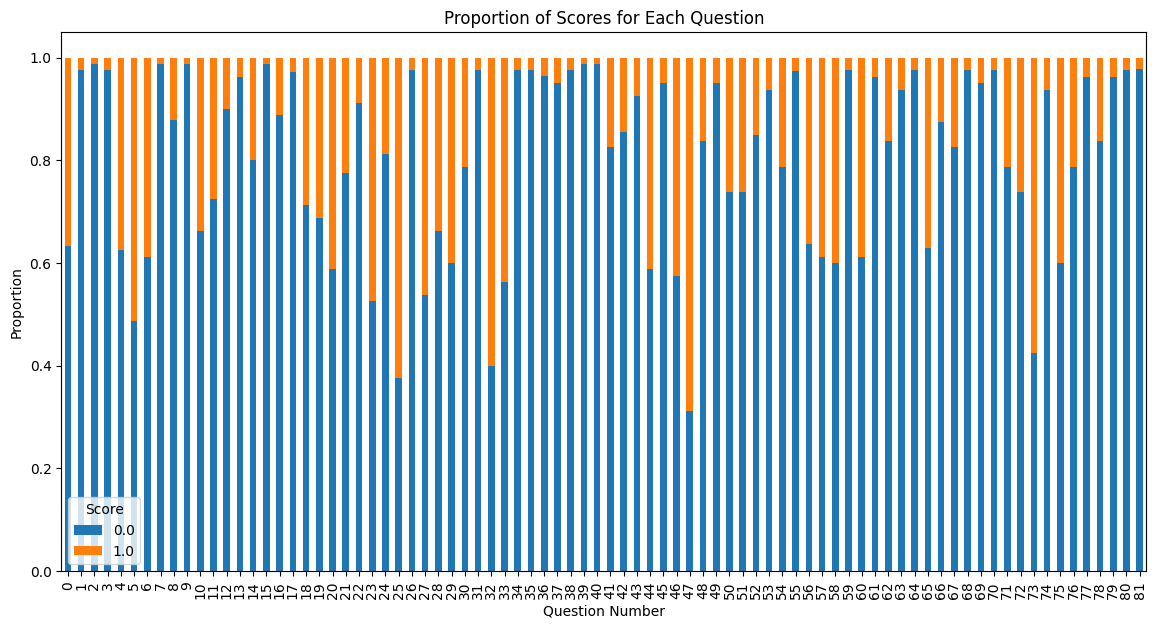

In [1]:
#load from csv
import pandas as pd
data = pd.read_csv('../data/finetuning/ce_finetuning_dataset.csv', header=0, names=['question_num', 'query', 'context', 'score'])

# Group the data by 'question_num' and 'score', then count occurrences
score_counts = data.groupby(['question_num', 'score']).size().unstack(fill_value=0)

# Calculate proportions of each score within each question
score_proportions = score_counts.div(score_counts.sum(axis=1), axis=0)

print(score_proportions)
import matplotlib.pyplot as plt

# Plotting the proportions of scores for each question
score_proportions.plot(kind='bar', stacked=True, figsize=(14, 7))
plt.title('Proportion of Scores for Each Question')
plt.xlabel('Question Number')
plt.ylabel('Proportion')
plt.legend(title='Score')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

# Create a dictionary to hold train and test splits
train_dataset = pd.DataFrame()
test_dataset = pd.DataFrame()

# Iterate through each group and split
for (question_num, score), group in data.groupby(['question_num', 'score']):
    train, test = train_test_split(group, test_size=0.1, random_state=42)  # Ensures a 10% split
    train_dataset = pd.concat([train_dataset, train])
    test_dataset = pd.concat([test_dataset, test])

# Reset the index for clean datasets
train_dataset.reset_index(drop=True, inplace=True)
test_dataset.reset_index(drop=True, inplace=True)

print("Training set size:", len(train_dataset))
print("Testing set size:", len(test_dataset))


In [ ]:
%pip install llama-index-legacy
%pip install llama-index-finetuning
%pip install llama-index-llms-openai
!pip install huggingface_hub --quiet

In [2]:
import pandas as pd
#for now train on the whole dataset
train_dataset = pd.read_csv('../data/finetuning/ce_finetuning_dataset.csv')
class CrossEncoderFinetuningDatasetSample:
    def __init__(self, query, context, score):
        self.query = query
        self.context = context
        self.score = score
finetuning_dataset = [CrossEncoderFinetuningDatasetSample(d[1], d[2], d[3]) for d in train_dataset.values]
print(len(finetuning_dataset))

from llama_index.legacy.finetuning.cross_encoders.cross_encoder import CrossEncoderFinetuneEngine
#from sentence_transformers import SentenceTransformer

# Initialise the cross-encoder fine-tuning engine
finetuning_engine = CrossEncoderFinetuneEngine(
    dataset=finetuning_dataset, epochs=5, batch_size=4
)

# Finetune the cross-encoder model
finetuning_engine.finetune()

6887


/Users/ethan/Documents/GitHub/test-buddy/venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1722 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1722 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1722 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1722 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1722 [00:00<?, ?it/s]

In [5]:
from huggingface_hub import notebook_login

notebook_login()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [6]:
finetuning_engine.push_to_hub(
    repo_id="ethan-cyj/Cross-Encoder-Finetuned",
)

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


## Evaluation

In [42]:
from sentence_transformers import CrossEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

base_model = 'cross-encoder/ms-marco-MiniLM-L-12-v2'
finetuned_model = 'ethan-cyj/Cross-Encoder-Finetuned'
def get_score(query, user_answer, model_name, threshold=0.5):
    # Tokenize the input data
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)
    inputs = tokenizer(query, user_answer, return_tensors='pt', truncation=True, padding=True)
    
    # Make predictions
    with torch.no_grad():
        logits = model(**inputs).logits

    # Apply softmax to get probabilities
    probabilities = torch.sigmoid(logits)

    # Get the predicted class and its probability
    predicted_class_id = 1 if probabilities.item() > threshold else 0
    predicted_class_probability = probabilities.item()

    return predicted_class_id, predicted_class_probability


In [44]:
results = []
df = pd.read_csv('../data/finetuning/test_dataset.csv', header=0, names=['question_no','query', 'context', 'score'])
for index, row in df.iterrows():
    query = row['query']
    context = row['context']
    score = row['score']
    base_prediction, base_probability = get_score(query, context, base_model)
    finetuned_prediction, finetuned_probability = get_score(query, context, finetuned_model)
    results.append({
        'query': query,
        'context': context,
        'label': score,
        'base_prediction': base_prediction,
        'base_probability': base_probability,
        'finetuned_prediction': finetuned_prediction,
        'finetuned_probability': finetuned_probability
    })


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Calculate metrics for the base model
base_accuracy = accuracy_score(results_df['label'], results_df['base_prediction'])
base_precision = precision_score(results_df['label'], results_df['base_prediction'])
base_recall = recall_score(results_df['label'], results_df['base_prediction'])
base_f1 = f1_score(results_df['label'], results_df['base_prediction'])
base_confusion = confusion_matrix(results_df['label'], results_df['base_prediction'])

# Calculate metrics for the finetuned model
finetuned_accuracy = accuracy_score(results_df['label'], results_df['finetuned_prediction'])
finetuned_precision = precision_score(results_df['label'], results_df['finetuned_prediction'])
finetuned_recall = recall_score(results_df['label'], results_df['finetuned_prediction'])
finetuned_f1 = f1_score(results_df['label'], results_df['finetuned_prediction'])
finetuned_confusion = confusion_matrix(results_df['label'], results_df['finetuned_prediction'])

# Print the metrics and confusion matrices
print("Base Model Metrics:")
print("Accuracy:", base_accuracy)
print("Precision:", base_precision)
print("Recall:", base_recall)
print("F1 Score:", base_f1)
print("Confusion Matrix:\n", base_confusion)

print("\nFinetuned Model Metrics:")
print("Accuracy:", finetuned_accuracy)
print("Precision:", finetuned_precision)
print("Recall:", finetuned_recall)
print("F1 Score:", finetuned_f1)
print("Confusion Matrix:\n", finetuned_confusion)

#save to csv
results_df.to_csv('../data/finetuning/results.csv', index=True)


/Users/ethan/Documents/GitHub/test-buddy/venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Base Model Metrics:
Accuracy: 0.7073170731707317
Precision: 1.0
Recall: 0.4146341463414634
F1 Score: 0.5862068965517241
Confusion Matrix:
 [[82  0]
 [48 34]]

Finetuned Model Metrics:
Accuracy: 0.9329268292682927
Precision: 0.9863013698630136
Recall: 0.8780487804878049
F1 Score: 0.9290322580645162
Confusion Matrix:
 [[81  1]
 [10 72]]


Further Prompting

In [48]:
answer = "Ischemic heart disease contributes to 18.8% of total mortality in Singapore, based on national health statistics from the Ministry of Health in 2019."
poor_answer = "Heart disease is a major killer in Singapore, but I'm not sure what the exact percentage is."
fair_answer = "In 2019, ischemic heart disease was responsible for approximately 19% of all deaths in Singapore, as reported by the Ministry of Health."
good_answer = "According to national health statistics from the Ministry of Health in 2019, ischemic heart disease accounts for approximately 19% of total mortality in Singapore."
# Get the scores for each answer
ft_poor_score = get_score(answer, poor_answer, finetuned_model)[1]
ft_fair_score = get_score(answer, fair_answer, finetuned_model)[1]
ft_good_score = get_score(answer, good_answer, finetuned_model)[1]
base_poor_score = get_score(answer, poor_answer, base_model)[1]
base_fair_score = get_score(answer, fair_answer, base_model)[1]
base_good_score = get_score(answer, good_answer, base_model)[1]
print("Base Model Scores:")
print("Poor Answers:", base_poor_score, ft_poor_score)
print("Fair Answers:", base_fair_score, ft_fair_score)
print("Good Answers:", base_good_score, ft_good_score)


/Users/ethan/Documents/GitHub/test-buddy/venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Base Model Scores:
Poor Answers: 0.8506933450698853 0.0247616246342659
Fair Answers: 0.9997695088386536 0.9998462200164795
Good Answers: 0.9999207258224487 0.9998886585235596
